# **Lab 02 - Large Language Models**

---

## **Lab 02:** Introduction to the Attention Mechanism and NLP Pipelines with Hugging Face

In this lab, we will better understand the mechanics of the **Attention Mechanism**, a critical component in many modern deep learning models, particularly in the field of **Natural Language Processing (NLP)** and **Large Language Models (LLMs)**. This session will provide a conceptual and practical understanding of how attention works and its role in enhancing model performance.

You will also be introduced to **Hugging Face**, one of the most widely-used libraries for NLP, and explore how to leverage pre-trained models for various language tasks. Throughout the lab, you will implement a basic **NLP pipeline**, applying attention-based models to process and analyze textual data.

The lab is structured to gradually build your familiarity with these tools. Initially, you will learn about the underlying principles of the attention mechanism and then move on to practical exercises that guide you through setting up your first NLP model using Hugging Face. By the end of this lab, you should be comfortable working with attention in PyTorch and building simple NLP pipelines.


In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import math

# set seed 
torch.manual_seed(42)
np.random.seed(42)

---

### **Exercise 1: Building a Simple Attention Mechanism for a Time Series Problem**

In this exercise, the goal is to design and implement a **simple attention mechanism** and apply it to a time series prediction problem. You will work with a synthetic time series dataset that features flat sequences with periodic jumps, and explore how attention can help the model focus on the most relevant time steps for better prediction accuracy.
The attention mechanism allows the model to assign varying importance to different parts of the input sequence, helping it to better capture temporal dependencies. 


#### **Creating a Synthetic Time Series Dataset with Jumps**

In this section, we define a **custom dataset class** that generates synthetic time series data with jumps at regular intervals. This class, `TimeSeriesDataset`, is designed to simulate a flat time series with pseudorandom spikes introduced at specific points. 
Each time series begins as a flat line and has a jump introduced at a random point within the first few time steps. Additional jumps occur at regular intervals, alternating between small and large jumps.

In [2]:
# Create a Synthetic Time Series Dataset (Flat with jumps)
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, seq_len, num_samples):
        val = 3
        self.seq_len = seq_len
        self.data = []
        for _ in range(num_samples):
            time_series = np.zeros(seq_len + 1)
            
            # Introduce the first jump at a random point between 0 and 2
            first_jump = np.random.randint(0, val)
            time_series[first_jump] += np.random.rand() + 5  # Add a random jump
            
            # Continue to introduce jumps every val timesteps after the first jump
            for i in range(first_jump + val, seq_len + 1, val):
                jump = 0 if i % 2 == 1 else 5
                time_series[i] += np.random.rand() + jump  # Add a random jump
            
            self.data.append(time_series)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        series = self.data[idx]
        return torch.tensor(series[:-1], dtype=torch.float32), torch.tensor(series[-1], dtype=torch.float32)

#### **Implementing the Scaled Dot-Product Attention Mechanism and Seq2Seq Model**

This section defines the **Scaled Dot-Product Attention Mechanism**, a core component in modern neural network models like Transformers. The attention mechanism operates by computing a weighted sum of the values, where the weights are determined by the similarity between the query and key. The similarity is scaled by the dimensionality of the key (`d_k`) to stabilize gradients.

The attention mechanism involves the following steps:
1. **Compute Scores**: The similarity between the query and key is calculated by taking their dot product.
2. **Scale the Scores**: The scores are divided by the square root of `d_k` to prevent large values from overwhelming the softmax.
3. **Masking** (Optional): A mask can be applied to prevent certain positions from influencing the attention weights. We will better understand the usefulness of masking in the second exercise, for now we do not care about it.
4. **Softmax and Output**: The attention weights are calculated using softmax, and the final output is computed by taking the weighted sum of the values.

Following this, a **Seq2Seq Model** with the scaled dot-product attention mechanism is defined. This model uses a Long-Short Term Memory (LSTM) to process input sequences and generate hidden states. The hidden state of the last LSTM cell serves as the query for the attention mechanism, while the entire sequence of hidden states is used as the keys and values.

The attention mechanism helps the model focus on the most relevant parts of the input sequence when making predictions. After applying the attention, the context vector is fed into a fully connected layer to produce the final output.


### **Scaled Dot-Product Attention Mechanism**

In this section, we define the **Scaled Dot-Product Attention** mechanism, a key component of the Transformer architecture that allows the model to focus on specific parts of the input sequence when making predictions.

The attention mechanism operates in the following steps:

- **Score Calculation**: The attention scores are calculated by taking the dot product between the query and the transposed key matrices. This operation measures how relevant each position in the key is to the query. The scores are scaled by the square root of the dimensionality of the key (`d_k`) to avoid large gradients, which could destabilize the training process.

- **Masking (Optional)**: If a mask is provided, it is applied to the scores by setting specific elements to a very large negative value. This prevents the model from attending to certain positions, which is particularly useful when handling padded sequences in time series or natural language tasks. For this particular problem the mask is not required, so it is not present in the implementation.

- **Softmax**: After computing the scaled scores, the softmax function is applied to normalize the scores into probabilities. This step ensures that the attention weights sum to 1 across each sequence position, allowing the model to attend to specific parts of the input more heavily.

- **Attention Output**: Finally, the attention weights are used to compute a weighted sum of the value matrix, generating the output. This allows the model to focus on important information in the sequence and ignore less relevant parts.

The attention mechanism returns both the final output and the attention weights, providing insight into which parts of the input the model is focusing on.


In [3]:
import torch
import torch.nn as nn

# Define the Scaled Dot-Product Attention Mechanism
class ScaledDotProductAttention(nn.Module):
    def __init__(self, seq_len, d_k, other_positional_encodings_present):
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = d_k
        self.seq_len = seq_len
        self.other_positional_encodings_present = other_positional_encodings_present
        self.rel_layer = torch.randn(1, self.seq_len, self.seq_len, requires_grad=True)

    def forward(self, query, key, value):
        # Compute the attention scores
        scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        
        # Add relative positional encodings if present
        if self.other_positional_encodings_present:
            scores = scores + self.rel_layer
        
        # Compute the attention weights
        attention_weights = torch.softmax(scores, dim=-1)
        
        # Compute the output
        output = torch.matmul(attention_weights, value)
        
        return output, attention_weights

### **Attention Mechanism in Transformer**

This section defines the **Attention** mechanism, a core component of the Transformer model, which allows the model to focus on different parts of the input sequence simultaneously. This mechanism helps the model capture multiple relationships and patterns within the data.

#### Key Components:

- **Linear Layers for Query, Key, and Value**: The input sequence is first transformed into query (`Q`), key (`K`), and value (`V`) vectors using linear transformations. These vectors represent the input in different spaces, allowing the model to calculate attention scores.

- **Attention Head**: The `AttentionHead` class implements a single attention head in a Transformer model. It transforms the input into query, key, and value vectors, computes attention scores, applies a softmax function to obtain attention weights, and produces the final attention output by computing a weighted sum of the value vectors.

- **Scaled Dot-Product Attention**: The head performs scaled dot-product attention by calculating the attention scores between the query and key vectors, scaling them, and applying a softmax function. The resulting attention weights are used to compute a weighted sum of the value vectors, producing the attention output.

- **Output Linear Layer**: The output from the attention head is passed through a final linear layer to produce the final output.

The `AttentionHead` class returns both the final output and the attention weights, enabling a deeper understanding of the model’s focus at each time step.


In [4]:
# Define a Multi-Head Attention mechanism (used in Transformer)
class AttentionHead(nn.Module):
    def __init__(self, d_model, seq_len, other_positional_encodings_present):
        super(AttentionHead, self).__init__()
        self.d_k = d_model
        self.seq_len = seq_len

        # Define linear layers for query, key, and value
        self.query_layer = nn.Linear(d_model, d_model)
        self.key_layer = nn.Linear(d_model, d_model)
        self.value_layer = nn.Linear(d_model, d_model)

        # Scaled dot-product attention
        self.scaled_dot_attention = ScaledDotProductAttention(self.seq_len, self.d_k, other_positional_encodings_present)

        # Output linear layer
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, query, key, value):
        batch_size = query.shape[0]
        
        # Apply linear layers to query, key, value
        Q = self.query_layer(query)
        K = self.key_layer(key)
        V = self.value_layer(value)

        # Apply scaled dot-product attention
        attention_output, attention_weights = self.scaled_dot_attention(Q, K, V)

        attention_output = attention_output.squeeze(1)       
        output = self.fc_out(attention_output)

        return output, attention_weights

### **Transformer Encoder Block**

The **TransformerEncoderBlock** defines a single block in the Transformer architecture, combining the attention mechanism with a feed-forward neural network and normalization layers. This block processes input sequences to capture complex relationships while maintaining stability during training through normalization and dropout.

#### Key Components:

- **Multi-Head Attention**: The input sequence is first passed through the **MultiHeadAttention** mechanism. This allows the model to focus on different parts of the sequence in parallel, attending to multiple aspects of the input. The multi-head attention output is then combined with the original input (via residual connection) after applying dropout for regularization.

- **Layer Normalization (Norm1)**: After multi-head attention, the output is passed through the first layer normalization step (`norm1`). This ensures that the model’s representations remain stable by normalizing the output along the feature dimension.

- **Feed-Forward Network (FFN)**: The output of the attention layer is further processed through a fully connected feed-forward neural network. This network consists of two linear layers with a ReLU activation function in between, allowing the model to capture nonlinear relationships. The `dim_feedforward` parameter controls the dimensionality of the hidden layer in the feed-forward network.

- **Layer Normalization (Norm2)**: After the feed-forward network, another residual connection is applied, followed by a second layer normalization (`norm2`). This helps stabilize the output of the block and prevent vanishing or exploding gradients during training.

- **Dropout**: Dropout is applied both after the attention mechanism and the feed-forward network to prevent overfitting by randomly setting some activations to zero during training.

This encoder block is a key building block in the Transformer model, enabling it to capture both local and global dependencies in the input sequence through attention and feed-forward networks.


In [5]:
# Define a basic Transformer Encoder block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, dim_feedforward, seq_len, other_positional_encodings_present, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.attention = AttentionHead(d_model, seq_len, other_positional_encodings_present)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Attention head
        attention_output, attention_weights = self.attention(x, x, x)
        x = self.norm1(x + self.dropout(attention_output))

        # Feed-forward network
        ffn_output = self.ffn(x)
        output = self.norm2(x + self.dropout(ffn_output))

        return output, attention_weights

### **Transformer Model for Time Series Prediction**

This section defines a **Transformer model** tailored for time series prediction. The model processes sequential data by combining embedding, positional encoding, and stacked Transformer encoder layers. It predicts a single output value based on the time series input.

#### Key Components:

- **Embedding Layer**: The time series input, which has a shape of `[batch_size, seq_len, input_size]`, is first passed through a linear embedding layer. This maps the input features to a higher-dimensional space with size `d_model`. The embedding allows the model to work in a more expressive feature space.

- **Positional Encoding**: Since Transformers are designed to process sequences without a built-in sense of order, positional encoding is added to provide information about the position of each time step in the sequence. This ensures the model can understand the temporal order of the input sequence. The positional encoding matrix is added to the embedded input data.

- **Transformer Encoder Layers**: The core of the model consists of multiple Transformer encoder blocks stacked together. Each encoder block contains a multi-head attention mechanism and a feed-forward neural network. The input data is passed through these layers sequentially. The model maintains attention weights from each layer, allowing insights into how the model attends to different parts of the sequence.

- **Output Layer**: After processing the sequence through the encoder layers, the final output is computed by applying a linear layer to the last time step of the sequence. The model focuses on the last time step to predict a single output value, suitable for tasks like time series regression.

In [6]:
# Define a simple Transformer Model
class Transformer(nn.Module):
    def __init__(self, input_size, d_model, dim_feedforward, num_layers, seq_len, positional_encoding = None, dropout=0.1, max_len=5000):
        super(Transformer, self).__init__()

        self.positional_encoding = positional_encoding

        # Embedding for the time series input
        self.embedding = nn.Linear(input_size, d_model)
        
        # Positional encoding for time series data
        if self.positional_encoding is not None:
            self.pos_encoder = self.positional_encoding(d_model, max_len)
        
        # Transformer encoder layers
        self.encoder_layers = nn.ModuleList(
            [TransformerEncoderBlock(d_model, dim_feedforward, seq_len, False if positional_encoding is not None else True, dropout) for _ in range(num_layers)]
        )
        
        # Output layer to predict a single value
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_size]
        
        # Embed the input time series data
        x = self.embedding(x)  # Shape: [batch_size, seq_len, d_model]    
        
        # Add positional encoding
        x = self.pos_encoder(x) if self.positional_encoding is not None else x
        
        # List to store attention weights from all layers
        all_attention_weights = []

        # Pass through each Transformer encoder layer
        for layer in self.encoder_layers:
            x, attention_weights = layer(x)
            all_attention_weights.append(attention_weights)

        # Apply final linear layer to get the output
        output = self.fc_out(x[:, -1])  # Take the output of the last time step (sequence regression)
        return output, all_attention_weights  # Return the final output and the attention weights

In [7]:
input_size = 1  # Number of input features
seq_len = 40 # Length of the time series sequence

d_model = 64  # Embedding dimension
dim_feedforward = 257  # Feedforward network dimension
num_layers = 3  # Number of Transformer encoder layers

model = Transformer(input_size, d_model, dim_feedforward, num_layers, seq_len)


In [8]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, target in dataloader:
            inputs = inputs.unsqueeze(2)  # Add feature dimension (batch_size, seq_len, input_size)
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs.squeeze(), target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')
    
    # Plot the loss history
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss During Training')
    plt.show()

In [9]:
batch_size = 128 # Number of samples in each batch
num_samples = 1000 # Number of samples in the dataset
num_epochs = 20 # Number of training epochs

Epoch 1/20, Loss: 7.761992692947388
Epoch 2/20, Loss: 6.091789066791534
Epoch 3/20, Loss: 5.165126383304596
Epoch 4/20, Loss: 3.8508657217025757
Epoch 5/20, Loss: 1.7138336300849915
Epoch 6/20, Loss: 0.4678332842886448
Epoch 7/20, Loss: 0.22058583423495293
Epoch 8/20, Loss: 0.13245000876486301
Epoch 9/20, Loss: 0.08171011321246624
Epoch 10/20, Loss: 0.05507580516859889
Epoch 11/20, Loss: 0.043649542378261685
Epoch 12/20, Loss: 0.03846773644909263
Epoch 13/20, Loss: 0.03593199048191309
Epoch 14/20, Loss: 0.034634028095752
Epoch 15/20, Loss: 0.03507158299908042
Epoch 16/20, Loss: 0.033760880352929235
Epoch 17/20, Loss: 0.03336341097019613
Epoch 18/20, Loss: 0.033765360713005066
Epoch 19/20, Loss: 0.03325938689522445
Epoch 20/20, Loss: 0.03193445922806859


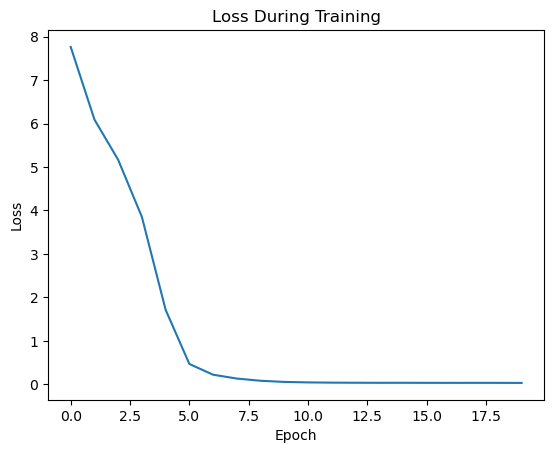

In [10]:
# Initialize the DataLoader
dataset = TimeSeriesDataset(seq_len, num_samples)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate the criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs=num_epochs)

### **Visualization of Normalized Attention Weights**

This plot displays the **Input Series** (blue line) along with the corresponding **Normalized Attention Weights** (orange dashed line). The normalized attention weights highlight the time steps that the Transformer model focuses on during the prediction process.

- The **normalized attention weights** are concentrated around time step 35, indicating that the model considers this region of the time series to be particularly important when making its prediction.
- The true target value is `5.51`, while the model's predicted value is `2.80`, showing that the model has learned to attend to certain key points in the sequence but still underestimates the final target.

This visualization provides insight into how the model allocates attention across different parts of the time series and illustrates its prediction process.


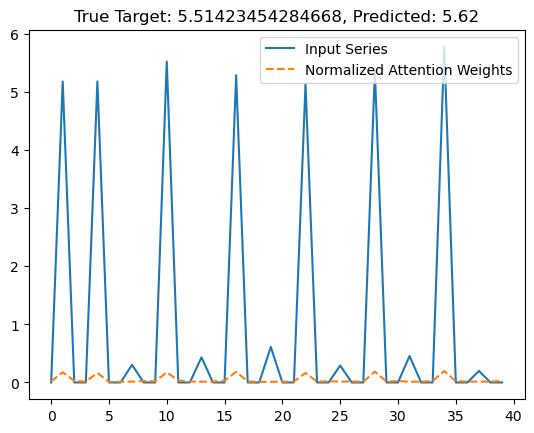

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Visualize the Attention Weights
def visualize_attention(model, dataset):
    model.eval()
    for i in range(len(dataset)):
        inputs, target = dataset[i]
        if target != 0: 
            # Reshape the input for the Transformer: [batch_size, seq_len, input_size]
            inputs = inputs.unsqueeze(0).unsqueeze(2)
            outputs, attention_weights = model(inputs)
            break

    # Plot the input time series (after undoing the batch and input dimension)
    plt.plot(inputs.permute(1, 0, 2).squeeze().numpy(), label="Input Series")

    # The attention weights are returned from all layers, so let's use the attention from the last layer
    attention_weights = attention_weights[-1][0].detach().numpy()  # [batch_size, num_heads, seq_len, seq_len]

    # Normalize attention weights for better visibility
    normalized_attention_weights = (attention_weights - np.min(attention_weights)) / (np.max(attention_weights) - np.min(attention_weights))
    
    
    # Plot the normalized attention weights
    plt.plot(normalized_attention_weights.mean(axis=0), label="Normalized Attention Weights", linestyle='--')
    plt.title(f"True Target: {target.item()}, Predicted: {outputs[-1].item():.2f}")
    plt.legend(loc='upper right')
    plt.show()



visualize_attention(model, dataset)

### **Positional Encoding for Time Series Data**

In this section, we define a **PositionalEncoding** class that adds positional information to the input data. Positional encodings are essential for the Transformer model to capture the order of the sequence since the attention mechanism itself is permutation-invariant.

The **PositionalEncoding** class creates a matrix of shape `(max_len, d_model)` where each position in the sequence is represented by a unique combination of sine and cosine functions. These functions vary with different frequencies based on the position in the sequence, which helps the model distinguish between different time steps.

- **Sine and Cosine Encodings**: The positional encodings alternate between sine and cosine functions for even and odd indices in the embedding dimension, allowing the model to encode sequential information effectively.
- **Batch Compatibility**: The positional encoding matrix is reshaped and registered as a buffer, meaning it is not updated during backpropagation but is available during forward passes.
- **Applying the Positional Encoding**: During the forward pass, the positional encoding is added to the input sequence to give each time step a unique representation based on its position.

By using this approach, the Transformer model can learn both the content and the position of each element in the input sequence, which is crucial for time series data.


In [23]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        # Create a matrix of shape (max_len, d_model) to hold the positional encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # Compute sine and cosine positional encodings
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # Apply sine to even indices in the encoding
        pe[:, 1::2] = torch.cos(position * div_term)  # Apply cosine to odd indices in the encoding
        
        pe = pe.unsqueeze(0).transpose(0, 1)  # Reshape for batch compatibility
        self.register_buffer('pe', pe)  # Register pe as a buffer so it doesn't get updated during backpropagation

    def forward(self, x):
        # Add positional encoding to the input
        return x + self.pe[:x.size(0), :].repeat(1,x.shape[1],1)

Epoch 1/20, Loss: 7.08028107881546
Epoch 2/20, Loss: 6.284349799156189
Epoch 3/20, Loss: 5.988515257835388
Epoch 4/20, Loss: 5.863435745239258
Epoch 5/20, Loss: 5.717653453350067
Epoch 6/20, Loss: 5.668702602386475
Epoch 7/20, Loss: 5.599805474281311
Epoch 8/20, Loss: 5.600651204586029
Epoch 9/20, Loss: 5.458144962787628
Epoch 10/20, Loss: 5.546176552772522
Epoch 11/20, Loss: 5.544108808040619
Epoch 12/20, Loss: 5.464274346828461
Epoch 13/20, Loss: 5.459318995475769
Epoch 14/20, Loss: 5.373415887355804
Epoch 15/20, Loss: 5.420028209686279
Epoch 16/20, Loss: 5.307478964328766
Epoch 17/20, Loss: 5.246327519416809
Epoch 18/20, Loss: 5.377385079860687
Epoch 19/20, Loss: 5.274801254272461
Epoch 20/20, Loss: 5.294715344905853


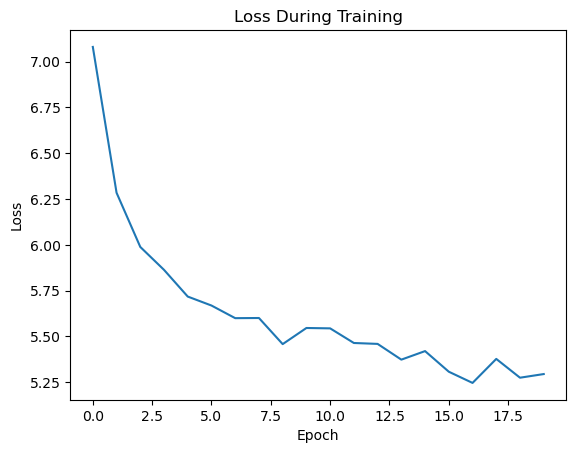

In [24]:
model = Transformer(input_size, d_model, dim_feedforward, num_layers, seq_len, PositionalEncoding)

# Instantiate the criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs=num_epochs)

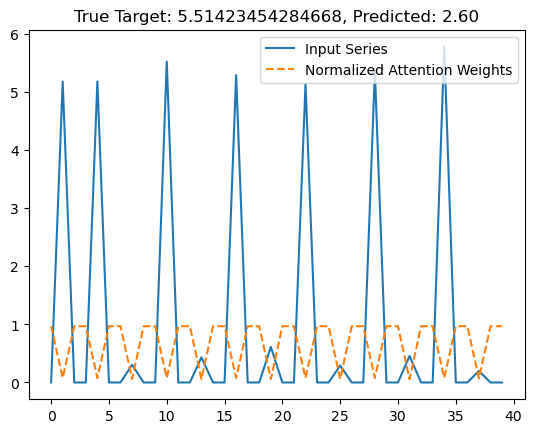

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Visualize the Attention Weights
def visualize_attention(model, dataset):
    model.eval()
    for i in range(len(dataset)):
        inputs, target = dataset[i]
        if target != 0: 
            # Reshape the input for the Transformer: [batch_size, seq_len, input_size]
            inputs = inputs.unsqueeze(0).unsqueeze(2)
            outputs, attention_weights = model(inputs)
            break

    # Plot the input time series (after undoing the batch and input dimension)
    plt.plot(inputs.permute(1, 0, 2).squeeze().numpy(), label="Input Series")

    # The attention weights are returned from all layers, so let's use the attention from the last layer
    attention_weights = attention_weights[-1][0].detach().numpy()  # [batch_size, num_heads, seq_len, seq_len]

    # Normalize attention weights for better visibility
    normalized_attention_weights = (attention_weights - np.min(attention_weights)) / (np.max(attention_weights) - np.min(attention_weights))
    
    
    # Plot the normalized attention weights
    plt.plot(normalized_attention_weights.mean(axis=0), label="Normalized Attention Weights", linestyle='--')
    plt.title(f"True Target: {target.item()}, Predicted: {outputs[-1].item():.2f}")
    plt.legend(loc='upper right')
    plt.show()



visualize_attention(model, dataset)

---

## **Exercise 2: Loading a Pre-Trained Model and Tokenizer with HuggingFace**

### Retrieving a Pre-trained Model from Hugging Face

Hugging Face’s `transformers` library provides a wide range of pre-trained models for Natural Language Processing (NLP) tasks. These models, trained on massive datasets, can be easily loaded and fine-tuned for specific tasks such as text classification, translation, summarization, and more. Among these models is **BERT** (Bidirectional Encoder Representations from Transformers), one of the most popular encoder-only transformer models.

One of the core functionalities of Hugging Face is the ability to retrieve models directly from their model hub, where thousands of **pre-trained** models are available. Each model is identified by a model name or a repository path, and it comes with a pre-trained tokenizer. The tokenizer is responsible for converting raw text into numerical representations (tokens) that the model can process, ensuring the text can be understood by the model.

The Hugging Face model hub provides models for various tasks, including:
- **Text Classification**: Sentiment analysis, topic classification, etc.
- **Question Answering**: Answering questions based on a provided context.
- **Summarization**: Generating concise summaries of input text.
- **Translation**: Translating text from one language to another.
- **Text Generation**: Generating new text based on an input prompt.

In this exercise, we will be using the **`google-bert/bert-base-uncased`** checkpoint, a pre-trained BERT model developed by Google. This model is uncased, meaning it treats uppercase and lowercase letters the same, which helps it generalize better for tasks where case sensitivity is not crucial. BERT is trained using both left and right context, making it powerful for a variety of NLP tasks such as classification, named entity recognition, and question answering. 


#### Steps to Retrieve a Pre-trained Model:
1. **Load the Pre-trained Model and Tokenizer**: The `AutoModel` and `AutoTokenizer` classes allow for easy loading of any pre-trained model and its corresponding tokenizer from the Hugging Face model hub. Models are specified by their model name or repository path. For this exercise, we’ll load `google-bert/bert-base-uncased`, a pre-trained BERT model designed for a wide range of natural language processing tasks.
   
2. **Tokenize Input Text**: Before feeding text into the model, it needs to be tokenized using the pre-trained **BERT tokenizer**. This step converts raw text into token IDs that the model can interpret. The BERT tokenizer uses **WordPiece tokenization** to handle out-of-vocabulary words and efficiently represent subwords. For example, "unhappiness" would be split into subword tokens like `["un", "##happy", "##ness"]`.

3. **Perform Inference**: Once the input is tokenized, it can be passed to the BERT model to perform inference. Depending on the task (e.g., classification, question answering), the model outputs logits or hidden states. For classification tasks, the raw logits can be transformed into probabilities using a softmax function, and the label with the highest probability represents the model's prediction.

Below is an example showing how to retrieve and use a pre-trained BERT model from Hugging Face for various NLP tasks.


In [ ]:
# Snippet to retrieve a model from Hugging Face
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define the model name or path from Hugging Face
model_name = "google-bert/bert-base-uncased"

# Load the pre-trained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions=True)

In this step, we define a sample text that we will use for sentiment analysis **TODO**

The tokenizer is then used to process the input text. The `tokenizer` converts the raw sentence into a format that the model can understand by breaking it down into tokens and converting them into numerical IDs. In this case, the method `tokenizer(text, return_tensors="pt", padding=True, truncation=True)` ensures that the output is in the correct tensor format (`return_tensors="pt"` for PyTorch), applies padding to ensure consistent input length across batches, and truncates the text if it exceeds the model's maximum sequence length. The output includes both **input IDs**, which are the tokenized numerical representations of the words, and an **attention mask**, which indicates which tokens should be attended to (where `1` signifies real tokens and `0` marks padding tokens). 

This ensures that only the relevant tokens are processed by the model, with the attention mask ignoring any padding that may have been added. By printing both the token IDs and the attention mask, we can inspect how the text has been prepared for model inference.

In [ ]:
# Define a sample text for sentiment analysis
text = "The dog ate the food because it was hungry"

# Tokenize the input text
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

# Print the tokens
print("Tokens:", inputs["input_ids"])
print("Attention Mask:", inputs["attention_mask"])

In [ ]:
# Convert tokens to IDs
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Print the token IDs
print("Tokens:", tokens)

In this step, we pass the tokenized input (which includes the attention mask) to the model for inference. The input is fed into the model using `model(**inputs)`, which performs forward propagation to generate the output. The model’s output contains multiple components, but in this case, we are specifically interested in the **logits**, which are the raw, unnormalized predictions made by the BERT model.

The **logits** represent the model's confidence in each class (for example, sentiment categories such as Negative, Neutral, and Positive) before applying any normalization. However, since the model hasn't been fine-tuned for a specific task yet, these logits won’t provide meaningful or reliable predictions at this point. 

For now, the output doesn't hold significant meaning, but this will be explored in detail in the next lab when we fine-tune the model for specific tasks. **For today's lab, we will limit ourselves to inference only in order to assess the attention weights of the model**. 

In [ ]:
# Pass the tokenized input (including attention mask) to the model
outputs = model(**inputs)

# Extract the logits (raw predictions) from the model output
logits = outputs.logits

# Apply softmax to get the predicted probabilities
probs = torch.nn.functional.softmax(logits, dim=-1)

# Print the predicted probabilities for each sentiment class
print("Softmax probabilities:", probs)

In this step, we focus on extracting and examining the **attention weights** produced by the model during inference. Attention weights provide insights into how the model distributes its focus across different tokens in the input sequence. By examining these weights, we can understand which words the model considers important when making predictions, especially in tasks like coreference resolution or sentiment analysis.

First, we extract the attention weights from the model’s output by accessing the `outputs.attentions` attribute. These attention weights are generated by the self-attention mechanism in transformer models like RoBERTa. Self-attention allows each token in the sequence to "attend" to other tokens, meaning it learns how much focus should be placed on surrounding words. This is crucial for capturing contextual relationships between words in a sentence.

Next, we print out the **number of attention layers** in the model using `len(attentions)`. Transformer models typically have multiple layers, each containing its own set of attention heads. For instance, BERT and RoBERTa base models generally have 12 layers, each of which processes the input tokens with attention mechanisms to refine the model's understanding of the sentence structure.

We also print the **shape of the attention weights** from the first layer with `attentions[0].shape`. This shape reveals key information about how the attention is structured:
- The first dimension represents the **batch size** (usually 1 in this case, as we are processing one sentence).
- The second dimension corresponds to the **number of attention heads** in that layer, which are independent mechanisms that attend to different parts of the input.
- The third and fourth dimensions both represent the **sequence length**, meaning how many tokens are in the input. Each token in the sequence attends to every other token, resulting in an attention matrix where every token has a score representing its attention to all other tokens.

By printing the shape of the attention weights, we get a clear understanding of the structure of the attention mechanism across different layers, heads, and tokens. This sets the foundation for visualizing or further analyzing how the model attends to specific words or entities in the input text.


In [ ]:
# Extract the attention weights from the output
attentions = outputs.attentions

# Print the attention weights shape
print(f"Number of attention layers: {len(attentions)}")
print(f"Shape of attention weights in the first layer: {attentions[0].shape}")

In this section, we use **Matplotlib** and **Seaborn** to visualize the attention weights extracted from the first attention head of the first layer in the transformer model. Visualizing attention weights allows us to better understand how the model distributes focus across the tokens in a sequence, showing which tokens "attend" to each other.

We create a **heatmap** to visualize the attention weights using **Seaborn’s** `heatmap()` function. A heatmap is an intuitive way to display how much attention each token pays to every other token in the sequence. The heatmap shows the attention matrix, where each row represents a token and each column represents how much attention that token places on other tokens. Darker shades indicate higher attention scores.

By visualizing the attention matrix, we can observe the relationships between tokens in the input sentence, such as whether certain words attend heavily to specific other words, providing insights into how the model understands the sentence contextually.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert attention weights to numpy array (taking the first attention head from the first layer)
attention_layer_1 = attentions[0][0, 0].detach().numpy()

# Plot the attention weights for the first layer, first attention head
plt.figure(figsize=(8, 8))
sns.heatmap(attention_layer_1, annot=False, cmap="Blues", xticklabels=tokens, yticklabels=tokens)
plt.xlabel("Attention to Token")
plt.ylabel("Token")
plt.title("Attention Weights - Layer 1, Head 1")
plt.show()
